In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys
import os
sys.path.append('../sensor_hub')
from data_utils import *

In [2]:
def draw_point_cloud(ax, points, axes=[0,1,2], point_size=0.1, xlim3d=None, ylim3d=None, zlim3d=None):
    axes_limits = [
        [-20, 80],
        [-20, 20],
        [-3, 3]
    ]
    axes_str = ['X','Y','Z']
    ax.grid(False)
    
    ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=points[:,3], cmap='gray')
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.xaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.yaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.zaxis.set_pane_color((1.0,1.0,1.0,0.0))
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

In [3]:
DATA_PATH = '/home/leli/autoware/volume/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync'
points = read_point_cloud(os.path.join(DATA_PATH, 'velodyne_points/data/%010d.bin'%0))

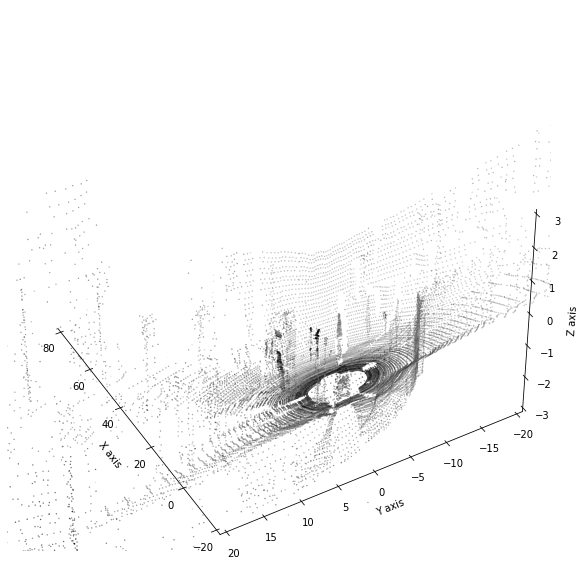

In [4]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 150)
draw_point_cloud(ax, points[::5])

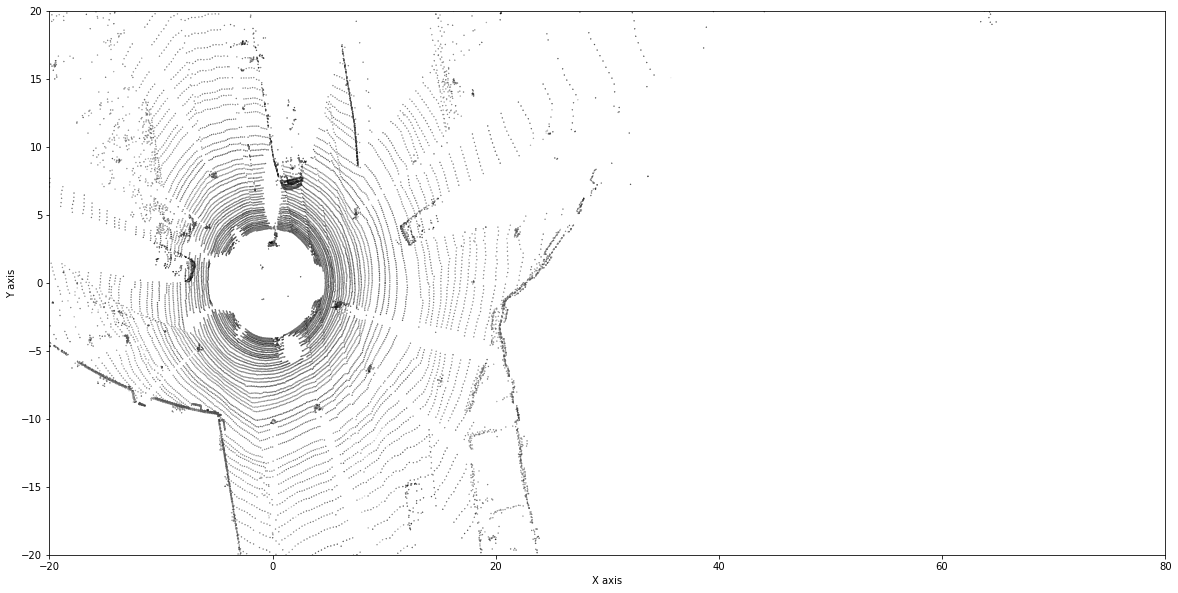

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points[::5], axes=[0,1])

In [6]:
df_tracking = read_tracking('/home/leli/autoware/volume/data/kitti/training/label_02/0000.txt')
df_tracking.head()

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
2,0,0,Car,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245
7,1,0,Car,0,0,-1.796862,294.898777,156.024256,452.199718,284.621269,2.000000,1.823255,4.433886,-4.650955,1.766774,13.581085,-2.121565
8,1,1,Cyclist,0,0,-1.935205,745.017137,156.393157,938.839722,374.000000,1.739063,0.824591,1.785241,1.700640,1.640419,5.778596,-1.664456


In [7]:
 def compute_3d_box_cam2(h,w,l,x,y,z,yaw):
    R = np.array([[np.cos(yaw), 0, np.sin(yaw)],[0,1,0],[-np.sin(yaw), 0, np.cos(yaw)]])
    x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2]
    corners_3d_cam2 = np.dot(R, np.vstack([x_corners,y_corners,z_corners]))
    corners_3d_cam2 += np.vstack([x,y,z])
    return corners_3d_cam2

In [8]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

In [9]:
corners_3d_cam2 = compute_3d_box_cam2(*df_tracking.loc[2,['height','width','length','pos_x','pos_y','pos_z','rot_y']])

In [10]:
corners_3d_cam2.shape

(3, 8)

In [11]:
corners_3d_cam2

array([[-6.48070602, -4.92129955, -2.62386198, -4.18326845, -6.48070602,
        -4.92129955, -2.62386198, -4.18326845],
       [ 1.858523  ,  1.858523  ,  1.858523  ,  1.858523  , -0.141477  ,
        -0.141477  , -0.141477  , -0.141477  ],
       [14.83425393, 15.77898154, 11.98673607, 11.04200846, 14.83425393,
        15.77898154, 11.98673607, 11.04200846]])

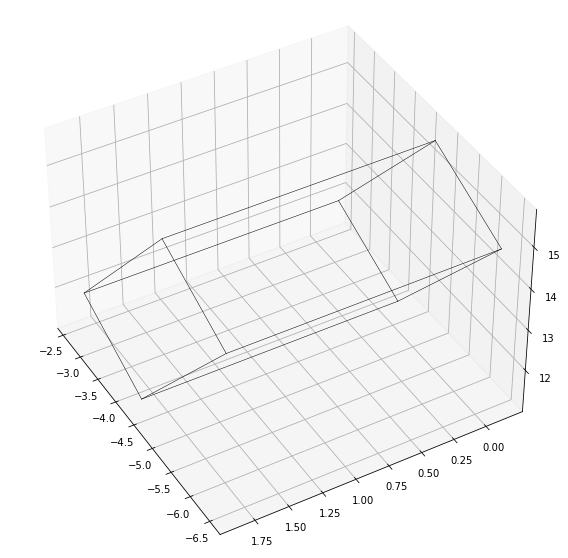

In [12]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 150)
draw_box(ax, (corners_3d_cam2))

In [13]:
from kitti_util import *

In [14]:
calib =Calibration('/home/leli/autoware/volume/data/kitti/RawData/2011_09_26/', from_video=True)
corners_3d_velo = calib.project_rect_to_velo(corners_3d_cam2.T).T

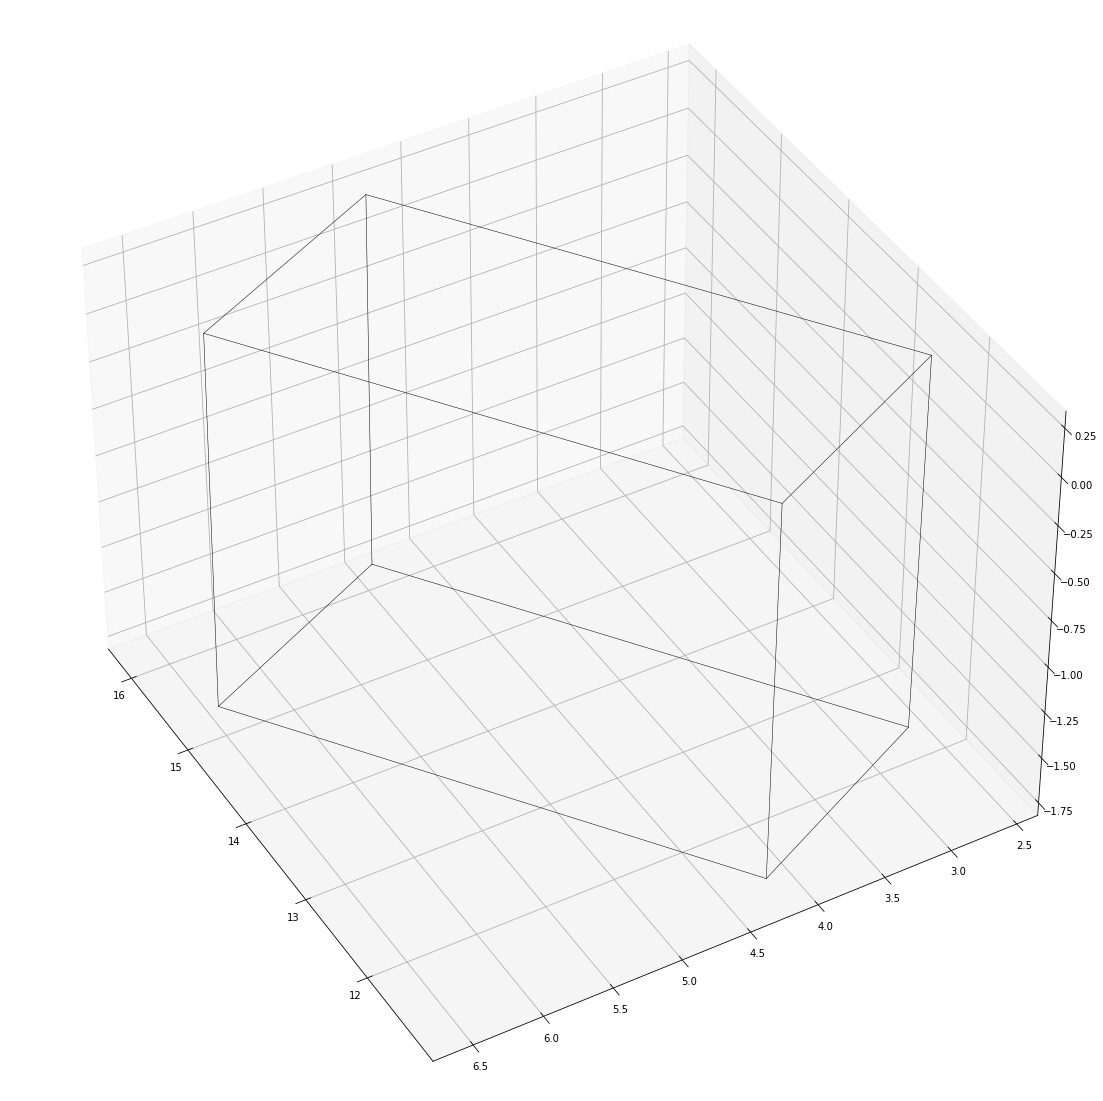

In [15]:
fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,150)
draw_box(ax, corners_3d_velo)

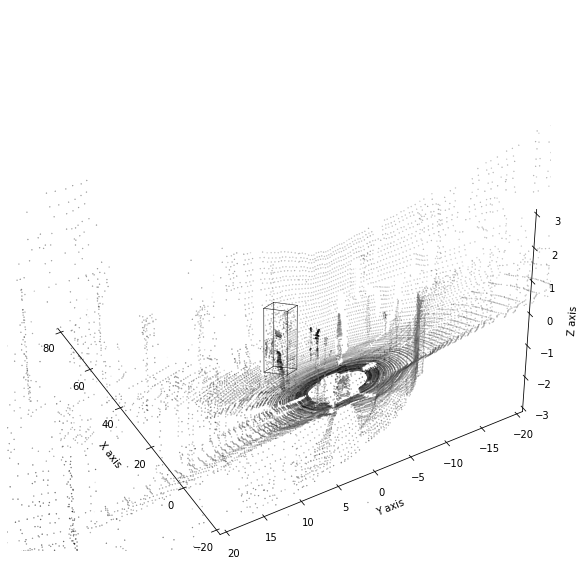

In [16]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 150)
draw_point_cloud(ax, points[::5])
draw_box(ax, corners_3d_velo)

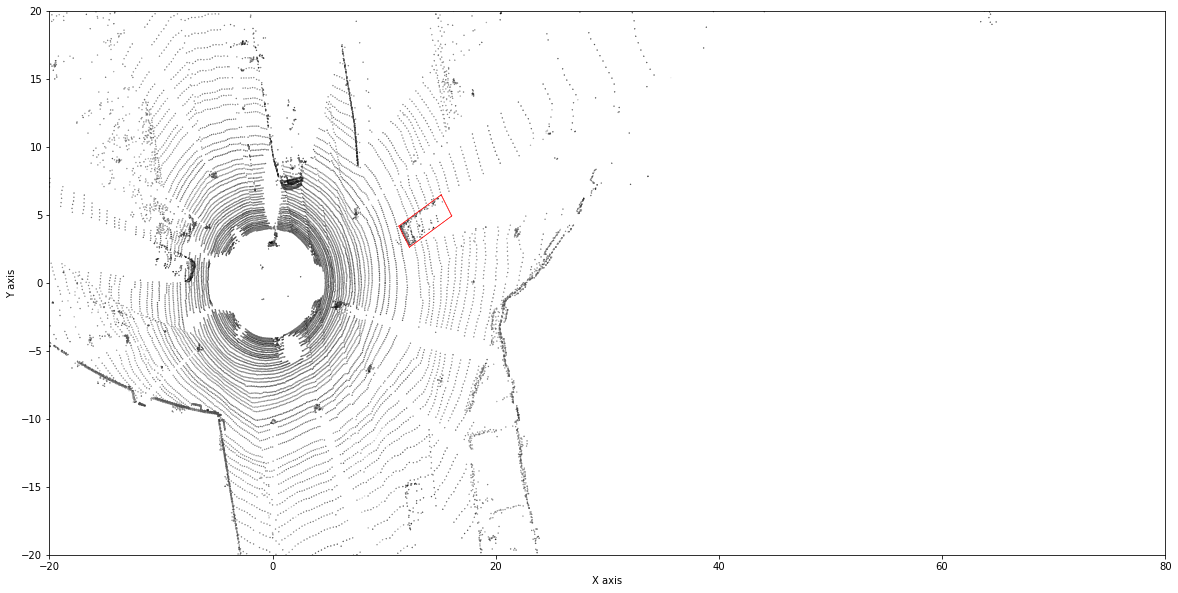

In [17]:
fig, ax = plt.subplots(figsize=[20, 10])
draw_point_cloud(ax, points[::5], axes=[0,1])
draw_box(ax, corners_3d_velo, axes=[0,1], color='r')

In [18]:
import pandas as pd
import numpy as np

IMU_COLUMN_NAMES = ['lat', 'lon', 'alt', 'roll', 'pitch', 'yaw', 'vn', 've', 'vf', 'vl', 'vu', 'ax', 'ay', 'az', 'af',
                    'al', 'au', 'wx', 'wy', 'wz', 'wf', 'wl', 'wu', 'posacc', 'velacc', 'navstat', 'numsats', 'posmode',
                    'velmode', 'orimode']
def read_imu(path):
    df = pd.read_csv(path, header=None, sep=' ')
    df.columns = IMU_COLUMN_NAMES
    return df

def compute_great_circle_distance(lat1, lon1, lat2, lon2):
    delta_sigma = float(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180)+ \
                        np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos(lon1*np.pi/180-lon2*np.pi/180))
    return 6371000.0 * np.arccos(np.clip(delta_sigma, -1, 1))

In [19]:
read_imu('/home/leli/autoware/volume/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/0000000000.txt')

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wf,wl,wu,posacc,velacc,navstat,numsats,posmode,velmode,orimode
0,49.011213,8.422885,112.834923,0.022447,0.00001,-1.22191,-3.325632,1.138431,3.514768,0.037625,...,-0.017499,0.021393,0.14563,0.492294,0.068884,4,10,4,4,0


In [20]:
prev_imu_data = None
gps_distance = []
imu_distance = []
for frame in range(150):
    imu_data = read_imu('/home/leli/autoware/volume/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/%010d.txt'%frame)
    if prev_imu_data is not None:
        gps_distance += [compute_great_circle_distance(imu_data.lat, imu_data.lon,prev_imu_data.lat, prev_imu_data.lon)]
        
        imu_distance += [0.1*np.linalg.norm(imu_data[['vf','vl']])]
    prev_imu_data = imu_data

In [21]:
gps_distance

[0.32886551901761646,
 0.3002117719193212,
 0.32886551901761646,
 0.32886551901761646,
 0.3002117719193212,
 0.3002117719193212,
 0.3002117719193212,
 0.25117518905986114,
 0.26851757186290587,
 0.3002117719193212,
 0.3002117719193212,
 0.3002117719193212,
 0.32886551901761646,
 0.3002117719193212,
 0.2848058938980103,
 0.32886551901761646,
 0.3148647627138235,
 0.3002117719193212,
 0.3002117719193212,
 0.32886551901761646,
 0.3002117719193212,
 0.34229408466787753,
 0.3002117719193212,
 0.3002117719193212,
 0.32886551901761646,
 0.3552153589000819,
 0.32886551901761646,
 0.32886551901761646,
 0.3552153589000819,
 0.32886551901761646,
 0.34229408466787753,
 0.3148647627138235,
 0.32886551901761646,
 0.34229408466787753,
 0.39142826111331763,
 0.3552153589000819,
 0.36768282798957014,
 0.4245635594323624,
 0.4027763577943589,
 0.4027763577943589,
 0.4452860177432757,
 0.4245635594323624,
 0.4138133700087314,
 0.4552936946604452,
 0.43504818905239795,
 0.43504818905239795,
 0.45529369466

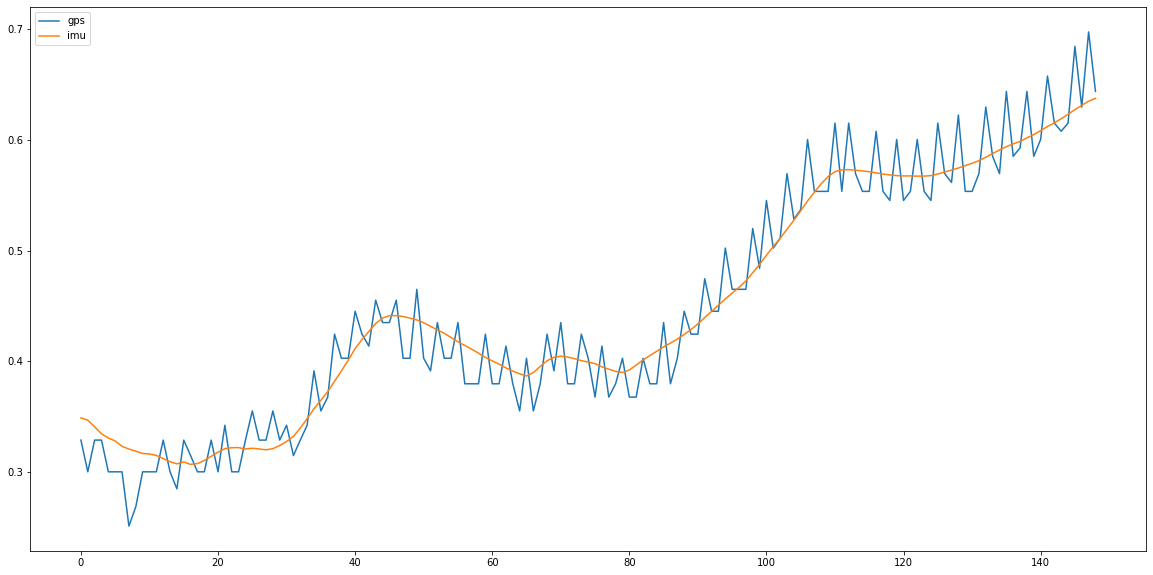

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(gps_distance, label='gps')
plt.plot(imu_distance, label='imu')
plt.legend()
plt.show()

In [23]:
prev_imu_data = None
locations = []

for frame in range(150):
    imu_data = read_imu('/home/leli/autoware/volume/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/oxts/data/%010d.txt'%frame)
    
    if prev_imu_data is not None: 
        displacement = 0.1*np.linalg.norm(imu_data[['vf','vl']])
        yaw_change = float(imu_data.yaw - prev_imu_data.yaw)
        for i in range(len(locations)):
            x0, y0 = locations[i]
            x1 = x0 * np.cos(yaw_change) + y0 * np.sin(yaw_change) - displacement
            y1 = -x0 * np.sin(yaw_change) + y0 * np.cos(yaw_change)
            locations[i] = np.array([x1, y1])
        
    locations += [np.array([0,0])]
    prev_imu_data = imu_data

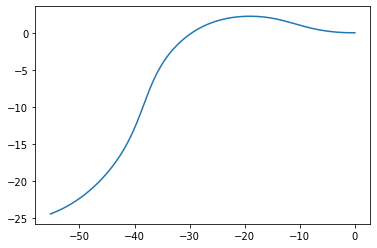

In [51]:
plt.plot(np.array(locations)[:,0], np.array(locations)[:,1])